In [1]:
import smith_watterman as sw
from testing import *
import os, sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# class to supress fuction output
# is used to run algorithm multiple times to know scores
class OnlyTest:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

/Users/daria/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### __Пример работы программы на двух случайных последовательностях__

Для самопроверки использовался сайт http://rna.informatik.uni-freiburg.de/Teaching/index.jsp?toolName=Smith-Waterman

Матрица переходов и получающиеся выравнивания моего и этого алгоритмов полностью совпадают

In [2]:
seq1 = random_seq(n=17)
seq2 = random_seq(n=14)

In [3]:
score = sw.water(seq1, seq2)

Given sequences
CCCAGCCTGTTAACACG
GGGGGGGGGATCGT
------------
CCTGT
GC-GT
Alignment score: 2.0
------------
CA-CG
GATCG
Alignment score: 2.0
------------
*** Alignments number: 2 ***


### __Влияние мисматчей и делеций на alignment score__

In [4]:
from collections import defaultdict
from tqdm import tqdm
with OnlyTest():
    scores = defaultdict(list)
    for t in ['mut', 'del']:
        for i in tqdm(range(5)):
            for _ in range(1000):
                seq1 = random_seq(n=20)
                if t == 'mut':
                    seq2 = change_seq(seq1, n=i, mutation=True)
                else:
                    seq2 = change_seq(seq1, n=i, mutation=False)
                scores[t + str(i+1)].append(sw.water(seq1, seq2))

100%|██████████| 5/5 [00:21<00:00,  4.18s/it]


In [5]:
df = pd.DataFrame(scores).melt()

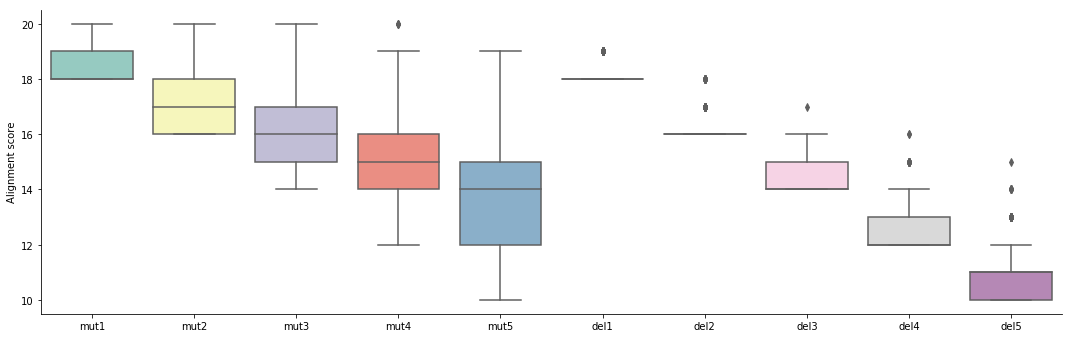

In [6]:
sns.catplot(kind='box', data=df, x='variable', y='value', palette="Set3", aspect=3)
plt.xlabel('')
plt.ylabel('Alignment score')

plt.show()

Видно, что при увеличении числа замен и делеций score падает. Заметно, что в случае замен дисперсия больше, для делеций же score падает более драматично, и делеции влияют примерно одинаково на разные последовательности.

### __Поведение веса выравнивания случайных независимых последовательностей от их длины__

Отправление выдачи в dev/null значительно снижает скорость работы программы, но мне показалось более разумным сделать так, нежели имплементировать отдельную функцию для тестирования

In [7]:
def make_plots(scores):
    df = pd.DataFrame(scores).melt()
    df.loc[:,'coeff'] = df.value / df.variable
    
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)

    sns.lineplot(data=df, x='variable', y='value')
    plt.xlabel('Sequence length')
    plt.ylabel('Alignment score')

    plt.subplot(1, 2, 2)
    sns.lineplot(data=df, x='variable', y='coeff')
    plt.xlabel('Sequence length')
    plt.ylabel('Alignment score / Sequence length')

    plt.tight_layout()

100%|██████████| 18/18 [01:21<00:00,  9.53s/it]


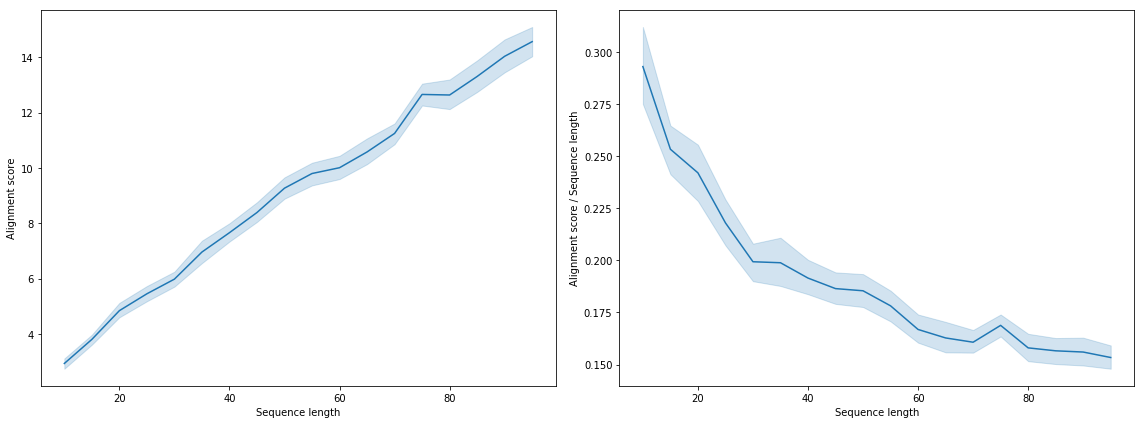

In [8]:
# default parameters
with OnlyTest():
    scores_length = defaultdict(list)
    for n in tqdm(range(10, 100, 5)):
        for _ in range(100):
            seq1 = random_seq(n=n)
            seq2 = random_seq(n=n)
            scores_length[n].append(sw.water(seq1, seq2))
make_plots(scores_length)

100%|██████████| 18/18 [01:23<00:00,  9.53s/it]


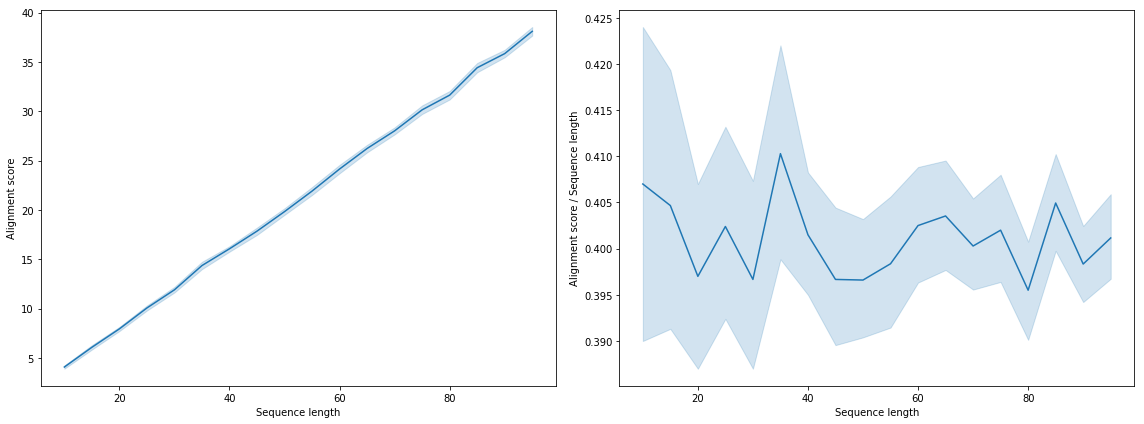

In [9]:
# zero mismatch penalty
with OnlyTest():
    scores_length = defaultdict(list)
    for n in tqdm(range(10, 100, 5)):
        for _ in range(100):
            seq1 = random_seq(n=n)
            seq2 = random_seq(n=n)
            scores_length[n].append(sw.water(seq1, seq2, mismatch = 0))
make_plots(scores_length)

100%|██████████| 18/18 [01:22<00:00,  9.36s/it]


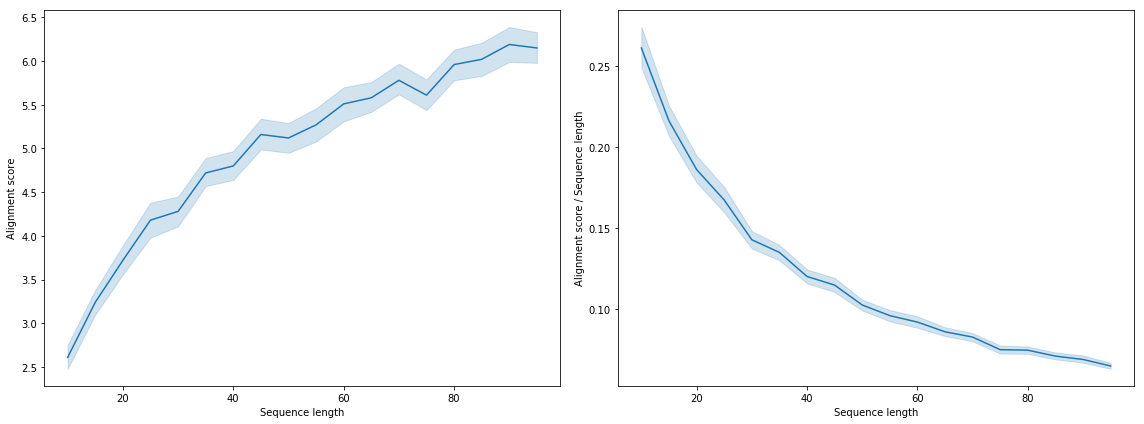

In [13]:
# big mismatch and gap penalty
with OnlyTest():
    scores_length = defaultdict(list)
    for n in tqdm(range(10, 100, 5)):
        for _ in range(100):
            seq1 = random_seq(n=n)
            seq2 = random_seq(n=n)
            scores_length[n].append(sw.water(seq1, seq2, mismatch = -100000, gap_penalty = -10000))
make_plots(scores_length)

Эффект ожидаемый, давайте проведем симуляцию

In [35]:
k_range = np.arange(1, 1000)
n_tries = 1000
vals = np.zeros((k_range.shape[0], n_tries))

In [39]:
for ind, k in enumerate(k_range):
    for i in range(n_tries):
        a = np.random.choice([0,1], size = (k, ), p = [0.75, 0.25])
        
        max_ser = 1
        ser = 0
        for j in range(1, a.shape[0]):
            if a[j] == 1:
                ser += 1
            else:
                if ser > max_ser:
                    max_ser = ser
                ser = 0
        if ser > max_ser:
            max_ser = ser
        vals[ind, i] = max_ser

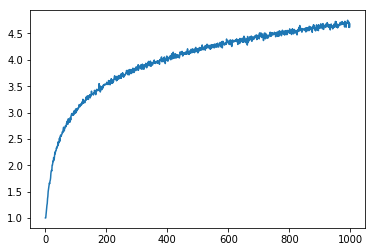

In [40]:
plt.plot(vals.mean(axis=1))

In [41]:
for ind, k in enumerate(k_range):
    for i in range(n_tries):
        a = np.random.choice([0,1], size = (k, ), p = [0.75, 0.25])
        max_ser = a.sum()
        vals[ind, i] = max_ser

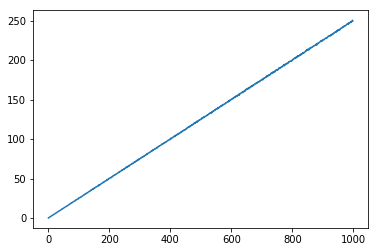

In [42]:
plt.plot(vals.mean(axis=1))

В случае с большим штрафом за гэп и мисматч, задача может быть переформулирована в задачу об ожидаемой длине наибольшей последовательности успехов в череде бернуллиевских испытаний. Пусть наша монетка biased с вероятностью $p$. Случайная величина $L_{n}$ - наибольшая последовательность успехов для $n$ испытаний. Ожидаемое число последовательностей длиной больше или равно единице можно найти по формуле $n(1-p)p$. Длиной больше или равно $k$ соответственно $n(1-p)p^{k}$. Можем аппроксимировать $L_{n}$: 
$$L_{n} \approx -log_{p} n(1-p) = log_{1/p} n(1-p)$$ Следовательно
$$ \frac{L_{n}}{log_{1/p} n(1-p)} \rightarrow 1$$
$$\forall \varepsilon > 0 \lim_{x\to \inf} P(| \frac{L_{n}}{log_{1/p} n(1-p)} - 1 | > \varepsilon) = 0 $$

В свою очередь отношение alignment score / длина последователььности приближается к Chvátal–Sankoff constants 